In [1]:
import pandas as pd
import numpy as np
import joblib
import sys
sys.path.append('../')

from premier_league import constants
if constants.RUN_DATA_EXPECTATIONS:
    from expectations_helpers import (
        AutoGreatExpectations,
        view_full_suite,
        view_suite_summary,
        save_expectations,
        load_expectations,
        validate_data
    )
from premier_league import (
    preprocessing,
    preprocessing_helpers,
    training,
    evaluation,
    prediction,
    data_extraction,
    visualisations,
    s3_helpers,
    postgres
)

Grabbing Passwords


In [2]:
import importlib
importlib.reload(constants)


<module 'premier_league.constants' from '/Users/david@inawisdom.com/Documents/Training/premier_league/notebooks/../premier_league/constants.py'>

In [4]:
df = s3_helpers.grab_data_s3(constants.TRAINING_DATA_LOCATION)
df = df[constants.COLUMNS_REQ]

In [5]:
df.head()

,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1995-96,19/08/95,Aston Villa,Man United,3.0,1.0,H
1,1995-96,19/08/95,Blackburn,QPR,1.0,0.0,H
2,1995-96,19/08/95,Chelsea,Everton,0.0,0.0,D
3,1995-96,19/08/95,Liverpool,Sheffield Weds,1.0,0.0,H
4,1995-96,19/08/95,Man City,Tottenham,1.0,1.0,D


### Set up data validation

In [6]:
if constants.RUN_DATA_EXPECTATIONS:
    ge_class = AutoGreatExpectations(df)

In [7]:
if constants.RUN_DATA_EXPECTATIONS:
    ge_data = ge_class.generate_expectations(verbose=False)

In [8]:
if constants.RUN_DATA_EXPECTATIONS:
    view_suite_summary(ge_data)

### Validate data

In [9]:
if constants.RUN_DATA_EXPECTATIONS:
    save_expectations(ge_data, constants.exp_loc)

In [10]:
if constants.RUN_DATA_EXPECTATIONS:
    data_expectations = load_expectations(constants.exp_loc)

In [11]:
if constants.INITIAL_DATA_LOAD:
    full_data = data_extraction.load_all_data(
        constants.TRAINING_DATA_LOCATION,
        constants.COLUMNS_REQ
    )
else:
    full_data = s3_helpers.grab_data_s3(
        constants.TRAINING_DATA_LOCATION)


In [12]:
full_data = data_extraction.add_new_data(
    full_data, 
    constants.COLUMNS_REQ,
    constants.TRAINING_DATA_LOCATION
)

Data saved at app_data/training_data_full.csv


In [13]:
if constants.RUN_DATA_EXPECTATIONS:
    validation_results = validate_data(full_data, data_expectations)

### Preprocessing

In [14]:
df = s3_helpers.grab_data_s3(constants.TRAINING_DATA_LOCATION)
df = df[constants.COLUMNS_REQ]
df.head()

,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1995-96,19/08/95,Aston Villa,Man United,3.0,1.0,H
1,1995-96,19/08/95,Blackburn,QPR,1.0,0.0,H
2,1995-96,19/08/95,Chelsea,Everton,0.0,0.0,D
3,1995-96,19/08/95,Liverpool,Sheffield Weds,1.0,0.0,H
4,1995-96,19/08/95,Man City,Tottenham,1.0,1.0,D


In [15]:
transformers = preprocessing.fit_transformers(
    df
)

In [16]:
s3_helpers.save_transformer_s3_pickle(
    transformers, 
    constants.TRANSFORMER_PATH
)

Transformer object is saved to S3 bucket premier-league-app at app_data/transformers/transformer_v2_20231118.pkl


In [17]:
transformed_data = preprocessing.transform_data(
    df, transformers
)

In [18]:
#transformed_data = transformed_data.drop(['HomeTeam', 'AwayTeam', 'season'], axis=1)

In [19]:
training_data, testing_data = preprocessing.split_data(transformed_data)

In [20]:
training_data.shape

(8608, 33)

In [21]:
testing_data.shape

(2152, 33)

In [22]:
training_data.head(2)

,season,HomeTeam,AwayTeam,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts,HomeLeaguePosition,AwayLeaguePosition,LeaguePositionDiff,MatchDayDay,MatchDayMonth,MatchDayDate
0,1999-00,Leeds,Arsenal,2,49.0,60.0,35.0,32.0,1.818182,1.818182,L,W,L,W,L,W,W,W,W,L,33.0,6,12,0.424242,0.848485,0.000000,-0.181818,2,3,-1,Sunday,April,16
1,1997-98,Blackburn,West Ham,0,33.0,25.0,19.0,28.0,1.894737,1.315789,W,W,W,L,L,W,W,W,W,L,19.0,12,9,0.736842,-0.157895,0.578947,0.157895,2,10,-8,Saturday,December,20


### Model Training

In [23]:
target_column = 'FTR'

In [24]:
hyperparameters = training.optimise_hyperparameters(
    training_data,
    target_column,
    max_evals = constants.MAX_EVALS
)

Entering fmin
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: -0.5267131242740999                                                                                           
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: -0.5319396051103368                                                                                           
100%|██████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/trial, best loss: -0.5319396051103368]


In [25]:
print(hyperparameters)

{'learning_rate': 0.020000000000000004, 'iterations': 500, 'max_depth': 2}


In [30]:
# Start postgresDB for model logging
postgres.start_rds_instance(constants.POSTGRES_DB_ID)

Error starting RDS instance: An error occurred (InvalidDBInstanceState) when calling the StartDBInstance operation: Instance premier-league-logging cannot be started as it is not in one of the following statuses: 'stopped, inaccessible-encryption-credentials-recoverable, incompatible-network (only valid for non-SqlServer instances)'.


In [38]:
classifier, run_id = training.train_model(
    training_data[[col for col in training_data if col != target_column]],
    training_data[target_column],
    hyperparameters = hyperparameters
)

In [39]:
s3_helpers.save_transformer_s3_pickle(
    classifier, 
    constants.CLASS_MODEL_NAME,
    is_transformer=False
)

Transformer object is saved to S3 bucket premier-league-app at app_data/models/classifier_v2_20231118.pkl


### Prediction

In [40]:
y_test = testing_data[target_column]
x_test = testing_data[[col for col in testing_data if col != target_column]]

In [41]:
predictions = prediction.predict(x_test, classifier)

### Evaluation

In [46]:
evaluation_metrics = evaluation.evaluate_model(
    predictions, 
    y_test,
    model_type='result',
    run_id=run_id
)

In [47]:
evaluation_metrics

{'mcc': 0.20779048292747504,
 'accuracy': 0.520910780669145,
 'f1': 0.4537820786231129,
 'confusion_matrix': [[826, 14, 169], [368, 22, 151], [319, 10, 273]]}

### Part 2: Predict Score

In [48]:
transformed_data = prediction.add_match_result(
    transformed_data, classifier, df )

In [49]:
s3_helpers.save_data_s3(
    transformed_data,
    constants.TRANSFORMED_DATA_LOCATION
)

In [50]:
transformed_data.shape

(10760, 36)

In [51]:
training_data, testing_data = preprocessing.split_data(transformed_data)

In [52]:
hyperparameters = training.optimise_hyperparameters(
    training_data.drop(['FTR','FTAG'], axis=1),
    'FTHG',
    classification=False,
    max_evals=constants.MAX_EVALS
)

Entering fmin
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: 1.5377564525869079                                                                                            
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: 1.5376852041340863                                                                                            
100%|███████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/trial, best loss: 1.5376852041340863]


In [61]:
regressor_1, run_id_home = training.train_model(
    training_data.drop(['FTR', 'FTHG','FTAG'], axis=1),
    training_data['FTHG'],
    model_type='home',
    verbose=False,
    hyperparameters = hyperparameters
)

In [62]:
s3_helpers.save_transformer_s3_pickle(
    regressor_1, 
    constants.HOME_MODEL_NAME,
    is_transformer=False
)

Transformer object is saved to S3 bucket premier-league-app at app_data/models/home_regress_model_v2_20231118.pkl


In [63]:
hyperparameters = training.optimise_hyperparameters(
    training_data.drop(['FTR', 'FTHG'], axis=1),
    'FTAG',
    classification=False,
    max_evals=constants.MAX_EVALS
)

Entering fmin
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: 1.1688236621869184                                                                                            
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: 1.1688051132833508                                                                                            
100%|███████████████████████████████████████████████| 2/2 [00:01<00:00,  1.17trial/s, best loss: 1.1688051132833508]


In [64]:
regressor_2, run_id_away = training.train_model(
    training_data.drop(['FTR', 'FTHG','FTAG'], axis=1),
    training_data['FTAG'],
    model_type='away',
    verbose=False,
    hyperparameters = hyperparameters
)

In [65]:
s3_helpers.save_transformer_s3_pickle(
    regressor_2, 
    constants.AWAY_MODEL_NAME,
    is_transformer=False
)

Transformer object is saved to S3 bucket premier-league-app at app_data/models/away_regress_model_v2_20231118.pkl


### Predict Home Goals

In [66]:
y_test = testing_data['FTHG']
x_test = testing_data.copy()

In [67]:
predictions_1 = prediction.predict(x_test, regressor_1)

In [68]:
evaluation_metrics = evaluation.evaluate_model(
    predictions_1, 
    y_test, 
    model_type='home',
    run_id=run_id_home    
)
evaluation_metrics

{'r2_score': 0.10556359768386692,
 'median_ae': 1.0,
 'mean_ae': 0.9172862453531598}

### Predict Away Goals

In [69]:
y_test = testing_data['FTAG']
x_test = testing_data.copy()

In [70]:
predictions_2 = prediction.predict(
    x_test, classifier)

In [71]:
evaluation_metrics = evaluation.evaluate_model(
    predictions_2, 
    y_test, 
    model_type='away',
    run_id=run_id_away
)
evaluation_metrics

{'r2_score': -0.46365444699587277,
 'median_ae': 1.0,
 'mean_ae': 1.0009293680297398}

### Visualisations of results

In [72]:
x_test['Home Prediction'] = predictions_1
x_test['Away Prediction'] = predictions_2

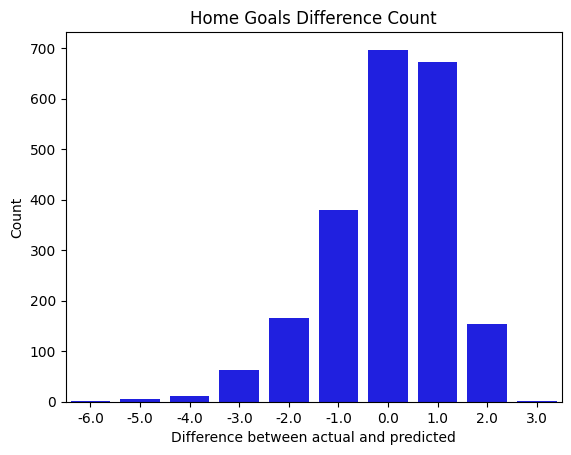

In [73]:
visualisations.histoplot(x_test, ha='Home')

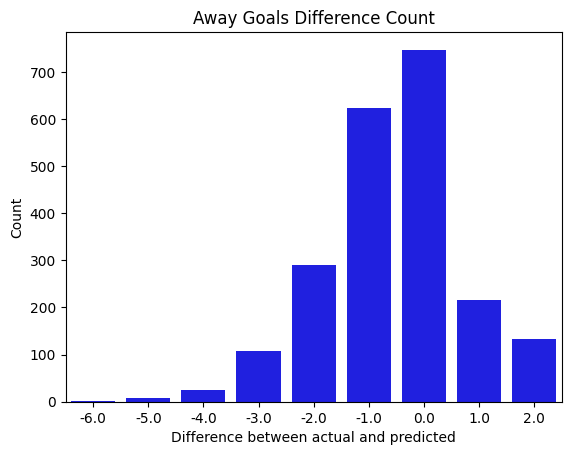

In [74]:
visualisations.histoplot(x_test, ha='Away')

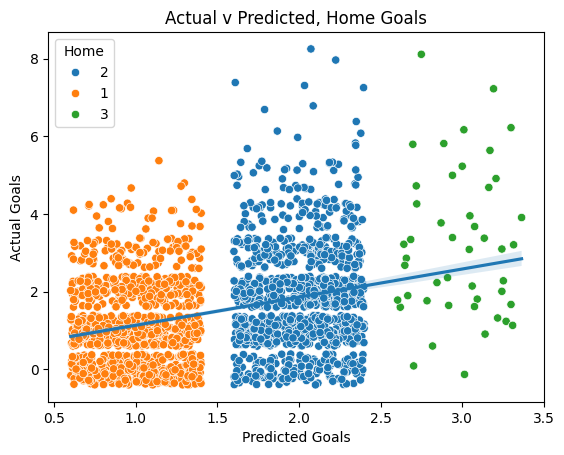

In [75]:
visualisations.actuals_predicted(x_test, ha='Home')

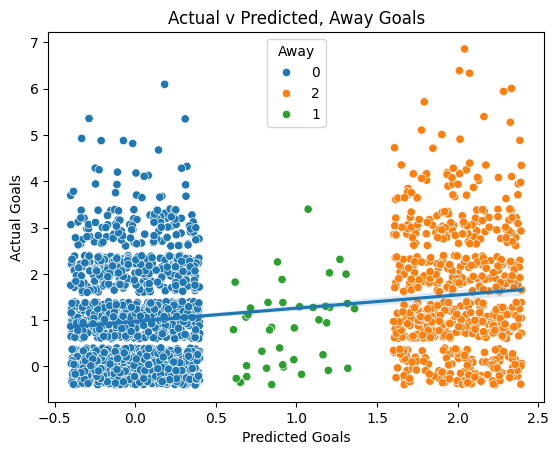

In [76]:
visualisations.actuals_predicted(x_test, ha='Away')

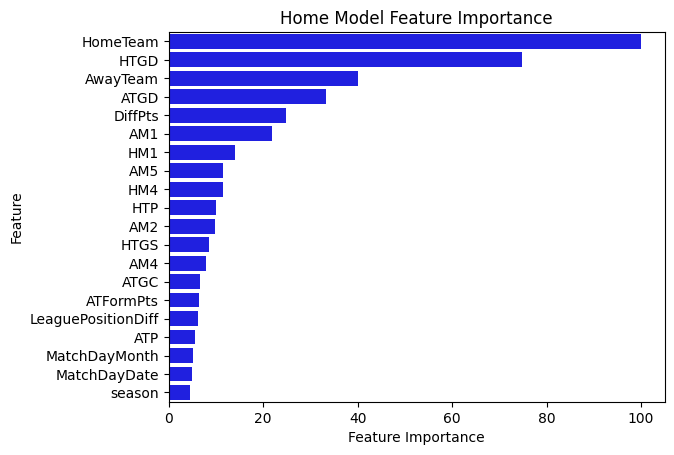

In [77]:
visualisations.plot_features(regressor_1, 'Home',n=20)

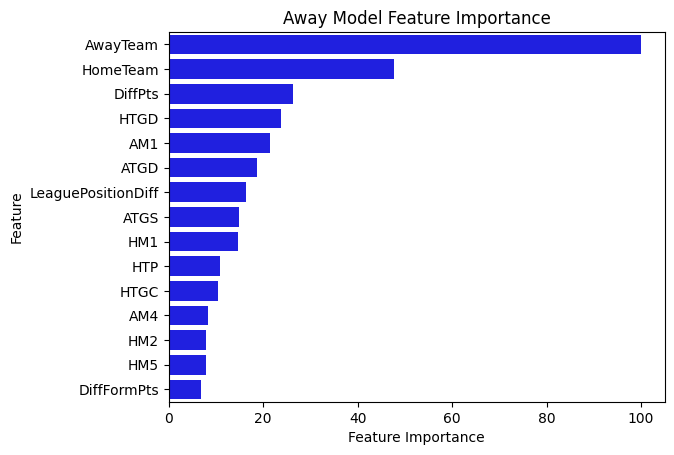

In [78]:
visualisations.plot_features(regressor_2, 'Away')

In [80]:
import mlflow


AttributeError: 'MlflowClient' object has no attribute 'list_experiments'